In [66]:
import numpy as np
import torch_geometric as tg
from scipy.sparse import csr_matrix 
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch.nn import functional as F
from torch_geometric.nn import GCNConv, ChebConv, GAE, VGAE, GATConv, AGNNConv
from torch_geometric.utils import dropout_adj
import torch_geometric.transforms as T
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from collections import Counter
import torch.nn as nn

In [43]:
npzfile = np.load("../data/trade_savez_files.npz", allow_pickle=True)
#_ = npzfile.seek(0)

In [44]:
npzfile.files

['attr_data',
 'attr_shape',
 'sparse_adj_trade',
 'sparse_adj_dists',
 'labels',
 'class_names']

In [45]:
node_attributes = npzfile['attr_data']
attribute_shape = npzfile['attr_shape']
trade_adj = npzfile['sparse_adj_trade']
dist_adj = npzfile['sparse_adj_dists']
class_labels = npzfile['labels']
class_names = npzfile['class_names']

In [46]:
dist_data_adj = dist_adj.tolist()
dist_edge_attr = dist_data_adj.data
dsrc, dtar = dist_data_adj.nonzero()[0], dist_data_adj.nonzero()[1]
dist_edge_index = torch.tensor([dsrc, dtar], dtype = torch.long)

In [47]:
trade_data_adj = trade_adj.tolist()
trade_edge_attr = torch.tensor(trade_data_adj.data, dtype = torch.float32)
tsrc, ttar = trade_data_adj.nonzero()[0], trade_data_adj.nonzero()[1]
node_attributes =torch.tensor(node_attributes, dtype = torch.float32)
trade_edge_index = torch.tensor([tsrc, ttar], dtype = torch.long)
y = torch.tensor(class_labels, dtype = torch.long)

In [48]:
n = len(node_attributes)
test_size = int(n * 0.3)
train_idx, test_idx = train_test_split(range(len(node_attributes)), test_size=test_size, random_state=42)
trade_data = Data(x = node_attributes, y = y, edge_index = trade_edge_index, edge_attr = trade_edge_attr)
test_size = int(len(trade_data.x) * 0.20) # Use 70% for training and 30% for testing
trade_data.train_idx = torch.tensor(train_idx, dtype=torch.long)
trade_data.test_idx = torch.tensor(test_idx, dtype=torch.long)

trade_data.train_mask = torch.cat((torch.zeros(test_size, dtype=torch.uint8), 
                                   torch.ones(n - test_size, dtype=torch.uint8)))

# trade_data.val_mask = torch.cat((torch.zeros(train_mask_size, dtype=torch.uint8), 
#                                  torch.ones(val_mask_size,dtype=torch.uint8), 
#                                  torch.zeros(test_mask_size ,dtype=torch.uint8)))

trade_data.test_mask = torch.cat((torch.zeros(n - test_size, dtype=torch.uint8), 
                                  torch.ones(test_size, dtype=torch.uint8)))

trade_data.num_classes = trade_data.y.max() + 1

In [69]:
def classifier_train_test(model_name, input_data, epochs = 1000, lr = 0.01, weight_decay = 0.0005):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: '.ljust(32), device)
    print('Model Name: '.ljust(32), str(model_name.__name__))
    print('Model params:{:19} lr: {:.4f}     weight_decay: {:.4f}'.format('',lr, weight_decay))    
    print('Total number of epochs to run: '.ljust(32), epochs)
    print('*' * 65)
    data = input_data.clone().to(device)
    infeat = data.num_node_features
    outfeat = data.num_classes.item()
    
    model = model_name(infeat, outfeat).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    train_losses, test_losses = [], []
    accs = []
    best_val_acc = 0
    best_train_loss = 0
    best_test_loss = 0
    best_epoch = 0
    model.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0
        test_loss = 0
        optimizer.zero_grad()
        out = model(data)
        train_loss = F.nll_loss(out[data.train_idx], data.y[data.train_idx])
        train_losses.append(train_loss.item())
        train_loss.backward()
        optimizer.step()

        model.eval()
        test_out = model(data)        
        #_ ,pred = model(data).max(dim = 1)
        test_loss = F.nll_loss(test_out[data.test_idx], data.y[data.test_idx])
        test_losses.append(test_loss)
        _ ,pred = test_out.max(dim = 1)
        correct  = float(pred[data.test_idx].eq(data.y[data.test_idx]).sum().item())
        acc = correct/ len(data.test_idx)
        tune.track.log(mean_accuracy=acc)
        
        if  best_val_acc < acc:
            best_val_acc = acc
            best_epoch = epoch
            best_train_loss = train_loss
            best_test_loss = test_loss
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        accs.append(acc)
        if (epoch % int(epochs/10) == 0): 
            print('Epoch: {}           Train loss: {:.4f}   Test loss: {:.4f}    Test Accuracy: {:.4f}'.format(epoch, train_loss, test_loss, acc))
        if (epoch == epochs):
            print('-'*65,'\nFinal epoch: {}     Train loss: {:.4f}   Test loss: {:.4f}     Test Accuracy: {:.4f}'.format(epoch, train_loss, test_loss, acc))
    print('-'*65)
    print('\033[1mBest Accuracy\nEpoch: {}     Train loss: {:.4f}   Test loss: {:.4f}     Test Accuracy: {:.4f}\n'
          .format(best_epoch, best_train_loss, best_test_loss, best_val_acc))
    
    fig = plt.figure(figsize = (12,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(range(1, epochs + 1) , train_losses, label = 'Train loss')
    ax1.plot(range(1, epochs + 1) , test_losses, label = 'Test loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Learning curve during training and testing')
    
    
    ax2 = fig.add_subplot(122)
    ax2.plot(range(1, epochs + 1) ,accs, label = 'Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('A plot of accuracy per epoch')
    
    plt.show()    

In [50]:
def run_GAE(input_data, epochs = 1000, lr = 0.01, weight_decay = 0.0005):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: '.ljust(32), device)
    print('Model Name: '.ljust(32), 'GAE')
    print('Model params:{:19} lr: {:.4f}   weight_decay: {:.4f}'.format('',lr, weight_decay))    
    print('Total number of epochs to run: '.ljust(32), epochs)
    print('*' * 70)
    
    data = input_data.clone().to(device)
    in_channels = data.num_features
    out_channels = data.num_classes.item()
    model = GAE(GAEncoder(in_channels, out_channels)).to(device)
    data = trade_data.clone().to(device)
    split_data = model.split_edges(data)
    x, train_pos_edge_index, edge_attr = split_data.x.to(device), split_data.train_pos_edge_index.to(device), data.edge_attr.to(device)
    split_data.train_idx = split_data.test_idx = data.y = None
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    train_losses, test_losses = [], []
    aucs = []
    aps = []
    model.train()
    for epoch in range(1, epochs+1):
        train_loss = 0
        test_loss = 0
        optimizer.zero_grad()
        z = model.encode(x, train_pos_edge_index)
        train_loss = model.recon_loss(z, train_pos_edge_index)
        train_losses.append(train_loss)
        train_loss.backward()
        optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            z = model.encode(x, train_pos_edge_index)
        auc, ap = model.test(z, split_data.test_pos_edge_index, split_data.test_neg_edge_index)
        test_loss = model.recon_loss(z, data.test_pos_edge_index)
        test_losses.append(test_loss.item())
        aucs.append(auc)
        aps.append(ap)
        if (epoch % int(epochs/10) == 0): 
            print('Epoch: {}       Train loss: {:.4f}    Test loss: {:.4f}     AUC: {:.4f}    AP: {:.4f}'.format(epoch, train_loss, test_loss, auc, ap))
        if (epoch == epochs):
            print('-'*65,'\nFinal epoch: {}    Train loss: {:.4f}    Test loss: {:.4f}    AUC: {:.4f}    AP: {:.4f}'.format(epoch, train_loss, test_loss, auc, ap))
    print('-'*65)
    
    fig = plt.figure(figsize = (12,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(range(1, epochs + 1) , train_losses, label = 'Train loss')
    ax1.plot(range(1, epochs + 1) , test_losses, label = 'Test loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Reconstruction loss on train and test')
    ax1.set_title('Learning curve for the Graph autoencoder')
    
    
    ax2 = fig.add_subplot(122)
    ax2.plot(range(1, epochs + 1) , aucs, label = 'AUC')
    ax2.plot(range(1, epochs + 1) , aps, label = 'AP')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC / AP')
    ax2.set_title('AUCs and APs on test sets')
    
    plt.show()    
    
    return

In [51]:
def run_baseline_GAE():
    
    return

In [52]:
def run_VGAE(input_data, epochs = 1000, lr = 0.01, weight_decay = 0.0005):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device: '.ljust(32), device)
    print('Model Name: '.ljust(32), 'VGAE')
    print('Model params:{:19} lr: {:.4f}     weight_decay: {:.4f}'.format('',lr, weight_decay))    
    print('Total number of epochs to run: '.ljust(32), epochs)
    print('*' * 70)
    
    data = input_data.clone().to(device)
    model = VGAE(VGAEncoder(data.num_features, data.num_classes.item())).to(device)
    data = model.split_edges(data)
    x, train_pos_edge_index, edge_attr = data.x.to(device), data.train_pos_edge_index.to(device), data.edge_attr.to(device)
    data.train_idx = data.test_idx = data.y = None
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_losses = []
    test_losses = []
    aucs = []
    aps = []
    model.train()
    for epoch in range(1, epochs + 1):
        train_loss, test_loss = 0, 0
        optimizer.zero_grad()
        z = model.encode(x, train_pos_edge_index)
        train_loss = model.recon_loss(z, train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
        train_losses.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            z = model.encode(x, train_pos_edge_index)
        auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
        test_loss = model.recon_loss(z, data.test_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
        test_losses.append(test_loss.item())
        aucs.append(auc)
        aps.append(ap)
        #print('AUC: {:.4f}, AP: {:.4f}'.format(auc, ap))
        if (epoch % int(epochs/10) == 0): 
            print('Epoch: {}        Train loss: {:.4f}    Test loss: {:.4f}    AUC: {:.4f}    AP: {:.4f}'.format(epoch, train_loss, test_loss, auc, ap))
        if (epoch == epochs):
            print('-'*65,'\nFinal epoch: {}  Train loss: {:.4f}    Test loss: {:.4f}    AUC: {:.4f}    AP: {:.4f}'.format(epoch, train_loss, test_loss, auc, ap))
    print('-'*65)
    
    
    fig = plt.figure(figsize = (12,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(range(1, epochs + 1) , train_losses, label = 'Train loss')
    ax1.plot(range(1, epochs + 1) , test_losses, label = 'Test loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Reconstruction loss')
    ax1.set_title('Learning curve for the Variational Graph autoencoder')
    
    
    ax2 = fig.add_subplot(122)
    ax2.plot(range(1, epochs + 1) , aucs, label = 'AUC')
    ax2.plot(range(1, epochs + 1) , aps, label = 'Average Precision score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC / AP')
    ax2.set_title('AUCs and Average Precision scores on test sets')
    
    plt.show()    

## Define Classification models for training

In [53]:
class GCNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNet, self).__init__()
        
        self.conv1 = GCNConv(in_channels, 2 * in_channels)#, cached=True)
        self.conv2 = GCNConv(2 * in_channels, out_channels)#data.num_classes)#, cached=True)
        # self.conv1 = ChebConv(data.num_features, 16, K=2)
        # self.conv2 = ChebConv(16, data.num_features, K=2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))#, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)#, edge_weight)
        return F.log_softmax(x, dim=1)

In [54]:
class ChebyNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ChebyNet, self).__init__()
        
#         self.conv1 = GCNConv(in_channels, 64)#, cached=True)
#         self.conv2 = GCNConv(64, out_channels=num_classes)#data.num_classes)#, cached=True)
        self.conv1 = ChebConv(in_channels, 64, K=2)
        self.conv2 = ChebConv(64, out_channels, K=2)

    def forward(self, data, use_edge_weight = False):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        if use_edge_weight:
            x = F.relu(self.conv1(x, edge_index, edge_weight))
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index, edge_weight)
        else:
            x = F.relu(self.conv1(x, edge_index))
            x = F.dropout(x, training=self.training)
            x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [55]:
class GATNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, 8 , heads=8, dropout=0.6)
        self.conv2 = GATConv( 8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x, edge_index, edge_weights = data.x, data.edge_index, data.edge_attr
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [56]:
class AGNNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AGNNet, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, 64)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(64, out_channels)

    def forward(self, data):
        x = F.dropout(data.x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, data.edge_index)
        x = self.prop2(x, data.edge_index)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [57]:
class GAEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
#         data = self.split_edges(data)
#         x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))#, edge_weight))
        return self.conv2(x, edge_index)#, edge_weight)

In [58]:
class baseline_GAEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, 2 * in_channels, cached=True)
        self.fc2 = nn.Linear(2 * out_channels, in_channels, cached=True)

    def forward(self, x, edge_index):
#         data = self.split_edges(data)
#         x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.fc1(x))#, edge_weight))
        return self.fc2(x)#, edge_weight)

In [59]:
class VGAEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGAEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logvar = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        mu, var = self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)
        return mu, var

In [60]:
class baseline_VGAEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(baseline_VGAEncoder, self).__init__()
        self.lin = nn.Linear(in_channels, 2 * in_channels)
        self.lin_mu = nn.Linear(2 * in_channels, out_channels)
        self.lin_logvar = nn.Linear(2 * in_channels, out_channels)
#         self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
#         self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
#         self.conv_logvar = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x):
        x = F.relu(self.lin(x))
        mu, var = self.lin_mu(x), self.lin_logvar(x, edge_index)
        return self.lin2(x)

In [61]:
class linear_baseline(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(linear_baseline, self).__init__()
        
        self.linear1 = nn.Linear(in_channel, 64)
        self.linear2 = nn.Linear(64, out_channel)
        
        
    def forward(self, data):
        x = data.x
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x)    

In [21]:
params = {'epochs': 10,  #Model parameters
          'lr' : 0.001,
          'weight_decay': 0.0005}

In [22]:
# Relative number of observations in train data
print(Counter(trade_data.y[trade_data.train_idx].numpy()))
# Relative number of observations in test data
print(Counter(trade_data.y[trade_data.test_idx].numpy()))

Counter({2: 22, 1: 22, 0: 17, 3: 17})
Counter({2: 12, 3: 9, 0: 7, 1: 5})


In [23]:
# Train with baseline logistic regression for node classification
X, y = trade_data.x.clone().numpy(), trade_data.y.clone().numpy()
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X[trade_data.train_idx.numpy()], y[trade_data.train_idx.numpy()])
#clf.predict(X[:2, :])
print('Classification score: ', clf.score(X[trade_data.test_idx.numpy()], y[trade_data.test_idx.numpy()]))
print('Predicted targets for test x: ', clf.predict(X[trade_data.test_idx.numpy()]))

Classification score:  0.696969696969697
Predicted targets for test x:  [1 0 2 2 3 3 3 2 2 3 3 1 0 0 2 1 0 0 0 1 1 2 3 2 1 0 1 1 0 2 2 0 2]


Device:                          cpu
Model Name:                      GCNet
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
*****************************************************************
Epoch: 1           Train loss: 1.5287   Test loss: 1.3566    Test Accuracy: 0.2424
Epoch: 2           Train loss: 1.3707   Test loss: 1.3663    Test Accuracy: 0.2121
Epoch: 3           Train loss: 1.3622   Test loss: 1.3792    Test Accuracy: 0.2121
Epoch: 4           Train loss: 1.3577   Test loss: 1.3860    Test Accuracy: 0.2121
Epoch: 5           Train loss: 1.3535   Test loss: 1.3831    Test Accuracy: 0.2121
Epoch: 6           Train loss: 1.3458   Test loss: 1.3742    Test Accuracy: 0.2121
Epoch: 7           Train loss: 1.3365   Test loss: 1.3652    Test Accuracy: 0.2424
Epoch: 8           Train loss: 1.3283   Test loss: 1.3589    Test Accuracy: 0.2424
Epoch: 9           Train loss: 1.3225   Test loss: 1.3550    Test Accuracy: 0.2424
Epoch:

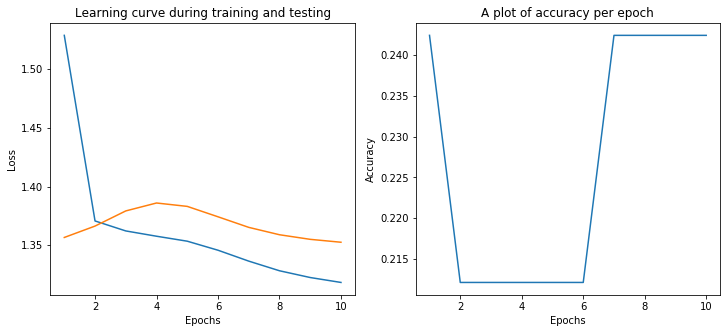

In [28]:
# Train node classifier with Graph Convolutional network

classifier_train_test(GCNet, trade_data, **params)

Device:                          cpu
Model Name:                      ChebyNet
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
*****************************************************************
Epoch: 1           Train loss: 1.8290   Test loss: 1.5953    Test Accuracy: 0.3939
Epoch: 2           Train loss: 1.4972   Test loss: 1.5422    Test Accuracy: 0.3939
Epoch: 3           Train loss: 1.4334   Test loss: 1.4919    Test Accuracy: 0.4242
Epoch: 4           Train loss: 1.3731   Test loss: 1.4453    Test Accuracy: 0.4242
Epoch: 5           Train loss: 1.3173   Test loss: 1.4021    Test Accuracy: 0.4242
Epoch: 6           Train loss: 1.2660   Test loss: 1.3623    Test Accuracy: 0.4242
Epoch: 7           Train loss: 1.2184   Test loss: 1.3257    Test Accuracy: 0.4848
Epoch: 8           Train loss: 1.1746   Test loss: 1.2921    Test Accuracy: 0.4848
Epoch: 9           Train loss: 1.1342   Test loss: 1.2609    Test Accuracy: 0.5152
Epo

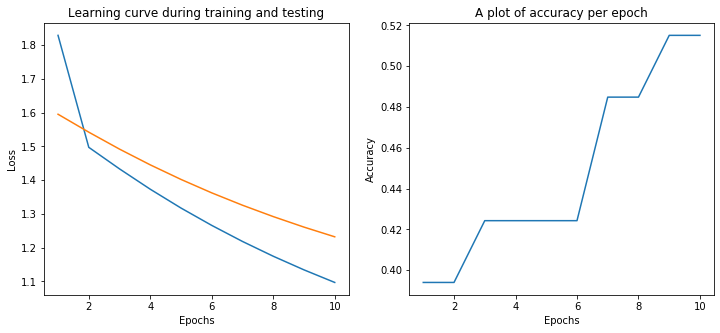

In [29]:
# Classification with ChebyNet

classifier_train_test(ChebyNet, trade_data, **params)

Device:                          cpu
Model Name:                      GATNet
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
*****************************************************************
Epoch: 1           Train loss: 18.9810   Test loss: 2.3617    Test Accuracy: 0.1212
Epoch: 2           Train loss: 2.0539   Test loss: 2.2331    Test Accuracy: 0.1212
Epoch: 3           Train loss: 1.9647   Test loss: 2.1076    Test Accuracy: 0.1212
Epoch: 4           Train loss: 1.8813   Test loss: 1.9983    Test Accuracy: 0.1212
Epoch: 5           Train loss: 1.8109   Test loss: 1.9037    Test Accuracy: 0.1212
Epoch: 6           Train loss: 1.7497   Test loss: 1.8195    Test Accuracy: 0.1212
Epoch: 7           Train loss: 1.6937   Test loss: 1.7427    Test Accuracy: 0.1212
Epoch: 8           Train loss: 1.6409   Test loss: 1.6727    Test Accuracy: 0.1212
Epoch: 9           Train loss: 1.5916   Test loss: 1.6102    Test Accuracy: 0.1212
Epoc

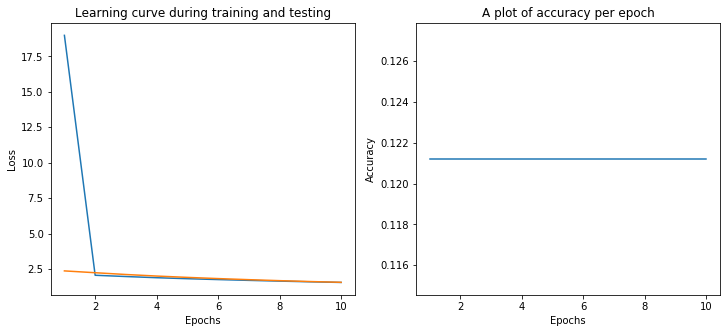

In [30]:
# Classification with Graph Attention Network

classifier_train_test(GATNet, trade_data, **params)

Device:                          cpu
Model Name:                      AGNNet
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
*****************************************************************
Epoch: 1           Train loss: 1.4321   Test loss: 1.4161    Test Accuracy: 0.2121
Epoch: 2           Train loss: 1.4178   Test loss: 1.4142    Test Accuracy: 0.2121
Epoch: 3           Train loss: 1.4122   Test loss: 1.4126    Test Accuracy: 0.2121
Epoch: 4           Train loss: 1.4067   Test loss: 1.4113    Test Accuracy: 0.2121
Epoch: 5           Train loss: 1.4014   Test loss: 1.4103    Test Accuracy: 0.2121
Epoch: 6           Train loss: 1.3964   Test loss: 1.4095    Test Accuracy: 0.1515
Epoch: 7           Train loss: 1.3918   Test loss: 1.4090    Test Accuracy: 0.1515
Epoch: 8           Train loss: 1.3875   Test loss: 1.4086    Test Accuracy: 0.1515
Epoch: 9           Train loss: 1.3837   Test loss: 1.4083    Test Accuracy: 0.1515
Epoch

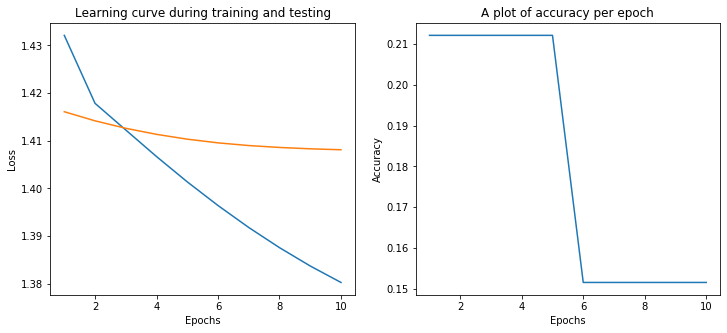

In [31]:
# Classification with Attention-based Graph Neural Network

classifier_train_test(AGNNet, trade_data, **params)

Device:                          cpu
Model Name:                      GAE
Model params:                    lr: 0.0010   weight_decay: 0.0005
Total number of epochs to run:   10
**********************************************************************
Epoch: 1       Train loss: 1.3741    Test loss: 1.4054     AUC: 0.9152    AP: 0.8975
Epoch: 2       Train loss: 1.3709    Test loss: 1.4055     AUC: 0.9198    AP: 0.8997
Epoch: 3       Train loss: 1.3683    Test loss: 1.4005     AUC: 0.9220    AP: 0.9000
Epoch: 4       Train loss: 1.3658    Test loss: 1.4007     AUC: 0.9230    AP: 0.8992
Epoch: 5       Train loss: 1.3613    Test loss: 1.4005     AUC: 0.9244    AP: 0.8997
Epoch: 6       Train loss: 1.3601    Test loss: 1.4014     AUC: 0.9250    AP: 0.9059
Epoch: 7       Train loss: 1.3581    Test loss: 1.3973     AUC: 0.9263    AP: 0.9075
Epoch: 8       Train loss: 1.3569    Test loss: 1.3945     AUC: 0.9261    AP: 0.9062
Epoch: 9       Train loss: 1.3548    Test loss: 1.3977     AUC: 0.9258  

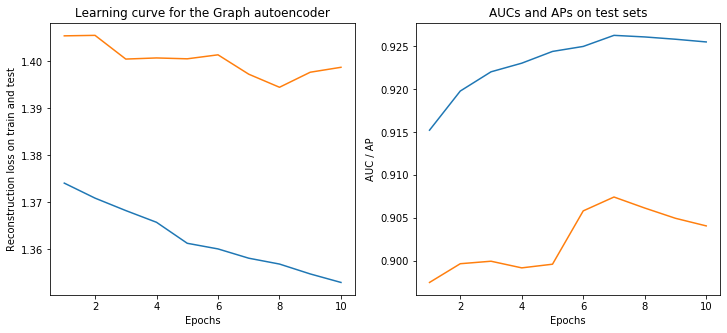

In [32]:
# Run Graph Autoencoder
run_GAE(trade_data, ** params)

Device:                          cpu
Model Name:                      VGAE
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
**********************************************************************
Epoch: 1        Train loss: 2.3970    Test loss: 1.4177    AUC: 0.6678    AP: 0.5525
Epoch: 2        Train loss: 1.4352    Test loss: 1.4031    AUC: 0.6460    AP: 0.5381
Epoch: 3        Train loss: 1.4246    Test loss: 1.4006    AUC: 0.6361    AP: 0.5319
Epoch: 4        Train loss: 1.4110    Test loss: 1.3934    AUC: 0.6394    AP: 0.5340
Epoch: 5        Train loss: 1.4038    Test loss: 1.3971    AUC: 0.6775    AP: 0.5590
Epoch: 6        Train loss: 1.3962    Test loss: 1.3876    AUC: 0.7046    AP: 0.5741
Epoch: 7        Train loss: 1.3901    Test loss: 1.3864    AUC: 0.7681    AP: 0.6253
Epoch: 8        Train loss: 1.3840    Test loss: 1.3849    AUC: 0.7950    AP: 0.6567
Epoch: 9        Train loss: 1.3767    Test loss: 1.3852    AUC: 0.895

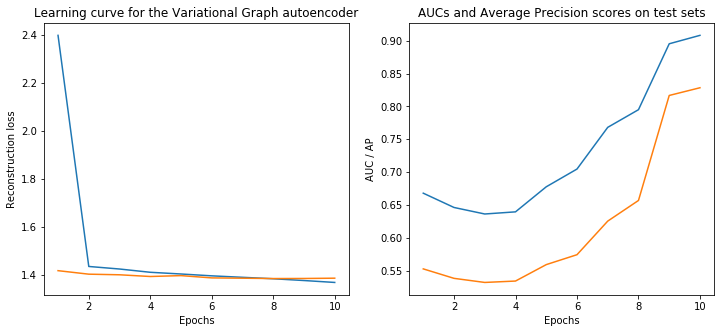

In [33]:
# Run Variational Graph Autoencoder
run_VGAE(trade_data, ** params)

In [35]:
#run_baseline_GAE(trade_data, **params)

In [37]:
#run_baseline_VGAE(trade_data, **params)

Device:                          cpu
Model Name:                      linear_baseline
Model params:                    lr: 0.0010     weight_decay: 0.0005
Total number of epochs to run:   10
*****************************************************************
Epoch: 1           Train loss: 1.3594   Test loss: 1.3629    Test Accuracy: 0.3030
Epoch: 2           Train loss: 1.3419   Test loss: 1.3492    Test Accuracy: 0.4242
Epoch: 3           Train loss: 1.3250   Test loss: 1.3356    Test Accuracy: 0.4545
Epoch: 4           Train loss: 1.3084   Test loss: 1.3221    Test Accuracy: 0.4848
Epoch: 5           Train loss: 1.2923   Test loss: 1.3086    Test Accuracy: 0.5455
Epoch: 6           Train loss: 1.2765   Test loss: 1.2951    Test Accuracy: 0.5758
Epoch: 7           Train loss: 1.2611   Test loss: 1.2816    Test Accuracy: 0.5758
Epoch: 8           Train loss: 1.2460   Test loss: 1.2683    Test Accuracy: 0.5758
Epoch: 9           Train loss: 1.2311   Test loss: 1.2551    Test Accuracy: 0.5

/home/kobbypanfordquainoo/anaconda3/envs/tgeom/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


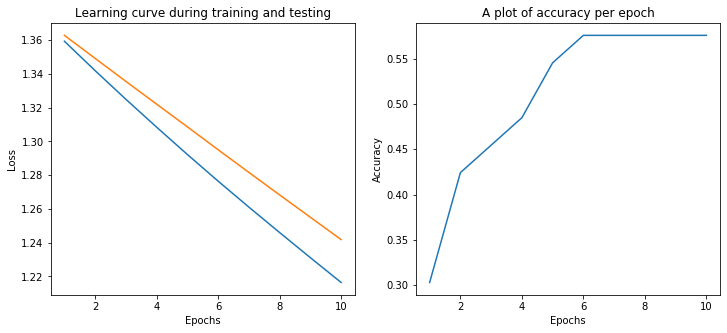

In [38]:
classifier_train_test(linear_baseline, trade_data, **params)

In [62]:
from ray import tune

In [63]:
def search_params():
    params = {'lr': (0.5, 0.3, 0.1), 'weight_decay' : (0.2,0.5)}
    clf = GridSearchCV(classifier_train_test, params, cv=5)
    clf.fit(trade_data)
    return best_params

In [76]:
def tune_params(config):
    lr = config['lr']
    weight_decay = config['weight_decay']
    params = {'lr': lr, 'weight_decay': weight_decay, 'epochs': 10}
    classifier_train_test(GATNet, trade_data, **params)


In [79]:
analysis = tune.run(tune_params, 
                    config={"lr": tune.grid_search([0.001, 0.01]), 
                            "weight_decay": tune.grid_search([0.005, 0.0005])
                           })


2019-10-25 18:43:42,937	INFO resource_spec.py:205 -- Starting Ray with 5.27 GiB memory available for workers and up to 2.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-10-25 18:43:42,939	INFO resource_spec.py:205 -- Starting Ray with 5.27 GiB memory available for workers and up to 2.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-10-25 18:43:42,940	INFO resource_spec.py:205 -- Starting Ray with 5.27 GiB memory available for workers and up to 2.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-10-25 18:43:42,942	INFO resource_spec.py:205 -- Starting Ray with 5.27 GiB memory available for workers and up to 2.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-10-25 18:43:42,943	INFO resource_spec.py:205 -- Starting Ray with 5.27 

ConnectionError: Error 111 connecting to 10.5.47.29:37172. Connection refused.

In [80]:
print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

Best config:  {'lr': 0.01}


In [78]:
!tensorboard --logdir ~/ray_results

TensorBoard 1.14.0a20190603 at http://aimsammi32:6006/ (Press CTRL+C to quit)
I1025 18:10:35.640799 140416171112192 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:35] "GET / HTTP/1.1" 200 -
I1025 18:10:36.612471 140416154326784 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GET /data/environment HTTP/1.1" 200 -
I1025 18:10:36.614010 140416145934080 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GET /data/runs HTTP/1.1" 200 -
I1025 18:10:36.614592 140416162719488 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GET /data/experiments HTTP/1.1" 200 -
I1025 18:10:36.615059 140416171112192 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GET /data/plugins_listing HTTP/1.1" 200 -
I1025 18:10:36.624497 140416171112192 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GET /data/plugins_listing HTTP/1.1" 200 -
I1025 18:10:36.697282 140416171112192 _internal.py:122] ::ffff:127.0.0.1 - - [25/Oct/2019 18:10:36] "GE